# The Weighted PageRank Algorithm

In this notebook, we'll cover an implementation of the Weighted PageRank algorithm. In the example here, we will be working exclusively with a directed graph.

PageRank was originally developed at Google by Larry Page and Sergey Brin. This algorithm is famous for being the original basis for the Google Search Engine. See: https://www.cis.upenn.edu/~mkearns/teaching/NetworkedLife/pagerank.pdf?ref=ruky.me

Here we will build upon the "vanilla" PageRank, where each edge is given equal importance when traversing a graph. In Weighted PageRank, the edges in a graph are given different levels of importance, or "weights", when traversing said graph. You can refer to this paper for more technical details on Weighted PageRank: http://delab.csd.auth.gr/~dimitris/courses/ir_spring06/page_rank_computing/01344743.pdf

Please refer to my previous notebook on PageRank here: https://github.com/insidelearningmachines/Blog/blob/main/Notebook%20XXIX%20Learn%20the%20PageRank%20Algorithm%20with%201%20Simple%20Example.ipynb 

In [1]:
import sknetwork as skn
import numpy as np
from IPython.display import SVG

And now we can run the notebook from the original PageRank post to load in the objects implemented there:

In [2]:
%run Notebook\ XXIX\ Learn\ the\ PageRank\ Algorithm\ with\ 1\ Simple\ Example.ipynb

In [3]:
# view the edges imported from the XXIX notebook
edges

[('A', 'B'),
 ('B', 'D'),
 ('D', 'A'),
 ('D', 'C'),
 ('A', 'C'),
 ('C', 'A'),
 ('D', 'E'),
 ('F', 'D')]

In [4]:
graph = skn.data.from_edge_list(edges, directed=True)

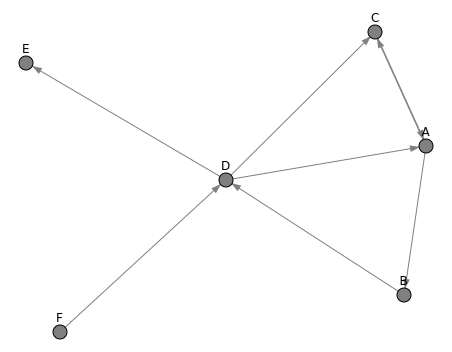

In [5]:
image = skn.visualization.graphs.visualize_graph(adjacency=graph.adjacency, names=graph.names, name_position='above')
SVG(image)

## The Algorithm

We saw in the previous post the update rule for PageRank over iteration $t=0,1,2,...$:

${\bf P_r(t+1)} = d{\bf \hat{O}P_r(t)} + \frac{1-d}{N_p}{\bf 1}$

where:

* $d$ is the damping factor
* $N_p$ is the number of nodes (i.e. webpages) in the graph
* ${\bf P_r(t)}$ is a column vector containing all the page ranks at step $t$
* ${\bf D}$ is a square diagonal matrix, where each element along the diagonal is either the inverse of the out-degree of node $i$, or $0.0$ if there are no outgoing edges
* ${\bf O}$ is the square adacency matrix for the graph
* ${\bf \hat{O}}$ is a modified form of the adacency matrix, where each element $\hat{O}_{i,j}$ is the ratio of edges from $j \rightarrow i$ divided by the total out-degree of node $j$
* ${\bf 1}$ is a column vector consisting of $N_p$ elements all set to 1.0

We can continue updating until convergence is reached as set by a tolerance parameter $\epsilon$:

$|{\bf P_r(t+1)} - {\bf P_r(t)}| < \epsilon$

For <u>Weighted PageRank</u>, we replace ${\bf \hat{O}}$ with a weights matrix ${\bf W}$ in our update rule such that:

${\bf P_r(t+1)} = d{\bf WP_r(t)} + \frac{1-d}{N_p}{\bf 1}$

and

${\bf W} = \begin{bmatrix} w_{0,0} && w_{0,1} && \cdots && w_{0,N_p} \\ 
                           w_{1,0} && w_{1,1} &&        && \vdots \\
                           \vdots    &&           && \ddots &&        \\
                           w_{N_p,0} && \cdots  &&        && w_{N_p,N_p} \end{bmatrix}$

where each element $w_{i,j}$ is the weight for the edge connecting nodes $j \rightarrow i$, and can take on a value between $[0.0,1.0]$. 

**Technically, ${\bf W}$ can be computed any way in which you desire to weight the edges. The choice for how you determine the weights will depend on the problem you're working on.**

For the specific case of web pages, we can determine each element of ${\bf W}$ by first computing:

$w_{i,j} = w^{in}_{j \rightarrow i} \times w^{out}_{j \rightarrow i}$

where: 

$w^{in}_{j \rightarrow i} = \frac{\textrm{number of incoming edges for} \: i}{\textrm{sum of all incoming edges for all nodes that link with} \: j}$

$w^{out}_{j \rightarrow i} = \frac{\textrm{number of outgoing edges for} \: i}{\textrm{sum of all outgoing edges for all nodes that link with} \: j}$

After computing each of these elements we can normalize the weights, with respect to all the outgoing edges from node $j$, to arrive at matrix ${\bf W}$.

## Implementation

Let's now proceed to implement the algorithm covered above:

In [6]:
class WeightedGraph(Graph):

    def _build_weight_matrix(self) -> np.array:
        W = np.zeros((len(self.nodes),len(self.nodes)))
        edges = np.array(self.edges)
        for node in self.nodes:
            # get all outgoing link nodes from node
            out_nodes = np.unique(edges[edges[:,0] == node][:,1])
            # get counts of incoming and outgoing links for all out_nodes
            I = np.array(list(map(self.indegrees.get, out_nodes)))
            I[I == None] = 0
            O = np.array(list(map(self.outdegrees.get, out_nodes)))
            O[O == None] = 0
            # compute weight components
            w_in = I/np.sum(I)
            w_out = O/np.sum(O)
            # fill in weights matrix
            col_idx = [self.nodes.index(node) for node in out_nodes]
            W[self.nodes.index(node),col_idx] = w_in*w_out
        return W

    def get_weighted_adjacency_matrix(self) -> np.array:
        # get the raw weight matrix
        W = self._build_weight_matrix()
        # normalize weights & return
        denominator = np.sum(W,axis=1)
        denominator = np.where(denominator == 0, 1., denominator)
        return (W.T/denominator)

In [7]:
class WeightedPageRank(PageRank):

    def _step(self, P1: np.array, I: np.array, graph: Graph) -> np.array:
        P2 = (
            self.damping_factor*np.matmul(graph.get_weighted_adjacency_matrix(),P1) 
            + (1 - self.damping_factor)*I/graph.get_number_nodes()
        )
        return(P2/np.sum(P2))

## Run the Weighted PageRank

Here let's test out the classes we just implemented, to see if the results make sense:

In [8]:
# create a graph object
graph = WeightedGraph(edges)

In [9]:
graph.get_weighted_adjacency_matrix()

array([[0.        , 0.        , 1.        , 0.66666667, 0.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , 0.33333333, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

Each column shows the fraction of the page rank that is distributed to other nodes at each iteration $t$. For example, the first column shows how the page rank of node A is distributed: 33.3% goes to node B, while 66.7% goes to node C.  

In [10]:
# create a pagerank object
pr = WeightedPageRank()

In [11]:
# compute pageranks
ranks = pr.evaluate(graph)

In [12]:
ranks

{'A': 0.3681734599108074,
 'B': 0.132187163250422,
 'C': 0.2859159868057953,
 'D': 0.16261318236879824,
 'E': 0.025555103832088505,
 'F': 0.025555103832088505}

Node | Original PageRank | Weighted PageRank
--- | --- | ---
A | 0.295 | 0.368
B | 0.163 | 0.132
C | 0.224 | 0.286
D | 0.202 | 0.163
E | 0.089 | 0.025
F | 0.027 | 0.025

Here we can see how the edge weights effect the ranking results. Some of the most notable changes is the increase in page rank to nodes A and C, whereas nodes B and D see a decrease. Node D is peculiar, in that it is linked to a dangling node (E). I covered dangling nodes in a recent video (https://www.youtube.com/watch?v=LSRgw7QE8Uk). The presence of such nodes will certainly effect the results, and as such if we properly treat for E, the rankings for both D and E will likely change.